# **Loading libraries and data**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('/content/drive/MyDrive/ITACADEMY(N)/data/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)


In [2]:
df = pd.read_csv('/content/drive/MyDrive/ITACADEMY(N)/data/train_masks.csv')
train_df = df[:4000]
val_df = df[4000:]

In [3]:
df

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...
...,...,...
5083,fff9b3a5373f_12.jpg,386005 13 387915 27 389829 34 391744 38 393660...
5084,fff9b3a5373f_13.jpg,393674 6 395585 19 397498 26 399412 32 401327 ...
5085,fff9b3a5373f_14.jpg,401397 9 403309 19 405223 26 405389 145 407138...
5086,fff9b3a5373f_15.jpg,407257 6 407393 89 409171 12 409263 179 411086...


In [4]:
for x, y in keras_generator(train_df, 8):
    break

In [5]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K

# create the base pre-trained model
base_model = VGG19(weights='imagenet', input_shape=(256,256,3), include_top=False)
 
base_out = base_model.output

80142336/80134624 [==============================] - 1s 0us/step


In [6]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

# **Building and fitting model**

In [7]:
conv1 = base_model.get_layer('block1_conv2').output
conv2 = base_model.get_layer('block2_conv2').output
conv3 = base_model.get_layer('block3_conv4').output
conv4 = base_model.get_layer('block4_conv4').output
conv5 = base_model.get_layer('block5_conv4').output

In [8]:
conv1

<KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv2')>

In [9]:
conv2

<KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>

In [10]:
conv3

<KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv4')>

In [11]:
conv4

<KerasTensor: shape=(None, 32, 32, 512) dtype=float32 (created by layer 'block4_conv4')>

In [12]:
conv5

<KerasTensor: shape=(None, 16, 16, 512) dtype=float32 (created by layer 'block5_conv4')>

In [19]:
up1 = UpSampling2D(2, interpolation='bilinear')(base_model.get_layer('block5_pool').output)
conc_1 = Concatenate()([up1, conv5])
conv_conc_1 = Conv2D(512, (3, 3), padding='same')(conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv4])
conv_conc_2 = Conv2D(256, (3, 3), padding='same')(conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv3])
conv_conc_3 = Conv2D(128, (3, 3), padding='same')(conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv2])
conv_conc_4 = Conv2D(64, (3, 3), padding='same')(conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conc_5 = Concatenate()([up5,conv1])
conv_conc_5 = Conv2D(32, (3, 3), padding='same')(conc_5)
conv_conc_5 = Activation('relu')(conv_conc_5)

conv_conc = Conv2D(1,(3,3),padding='same')(conv_conc_5)
conv_conc = Activation('sigmoid')(conv_conc)

model = Model(inputs=base_model.input, outputs=conv_conc)

In [20]:
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [21]:
batch_size = 8
model.fit(keras_generator(train_df, batch_size),
              steps_per_epoch=35,
              epochs=5,
              verbose=1,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/5
35/35 [==============================] - 131s 4s/step - loss: 0.3790 - val_loss: 0.0299
Epoch 2/5
35/35 [==============================] - 116s 3s/step - loss: 0.0269 - val_loss: 0.0206
Epoch 3/5
35/35 [==============================] - 105s 3s/step - loss: 0.0194 - val_loss: 0.0169
Epoch 4/5
35/35 [==============================] - 96s 3s/step - loss: 0.0157 - val_loss: 0.0154
Epoch 5/5
35/35 [==============================] - 92s 3s/step - loss: 0.0147 - val_loss: 0.0148


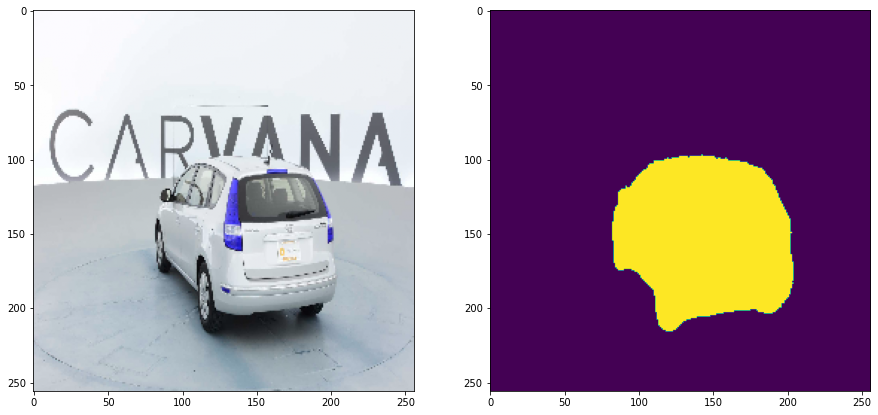

In [22]:
pred = model.predict(x)

im_id = 5
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()